# AI-Powered Autonomous Retail Shelf Monitoring System
Product detection and classification on images. Analyzing detection outputs (counts) to classify shelf status (in-stock vs. out-of-stock).

### Imports and Setup

In [1]:
import os
import re
import glob
import uuid
import random
import shutil
import tempfile
import subprocess
from itertools import islice
from collections import Counter, defaultdict

import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import ultralytics
from ultralytics import YOLO
from roboflow import Roboflow

from flask import Flask, request, render_template_string, send_from_directory, url_for

# Check ultralytics environment setup
ultralytics.checks()

Ultralytics YOLOv8.0.0  Python-3.8.10 torch-1.10.2+cu102 CUDA:0 (NVIDIA GeForce 940MX, 4096MiB)
Setup complete  (8 CPUs, 23.9 GB RAM, 453.2/476.3 GB disk)


### Download Dataset from Roboflow
This will create a folder like Retail-Product-Checkout and a data.yaml

In [2]:
# === Define local dataset folder name ===
DATASET_NAME = "retail-product-checkout-35"
DATASET_PATH = os.path.join(os.getcwd(), 'data', DATASET_NAME)

# === Check if dataset folder already exists ===
if os.path.exists(DATASET_PATH):
    print(f"[INFO] Dataset already exists at {DATASET_PATH}")
    class DummyDataset:
        def __init__(self, location):
            self.location = location
    dataset = DummyDataset(location=DATASET_PATH)

else:
    # Download from Roboflow if not present
    rf = Roboflow(api_key="a7ixfLNh5wtqHUYhxvQf")
    project = rf.workspace("cdio-zmfmj").project("retail-product-checkout")
    dataset = project.version(35).download("yolov8")

print(f"[INFO] Using dataset at: {dataset.location}")

[INFO] Dataset already exists at C:\Users\HP\PGC - AI\FSDSS Project\data\retail-product-checkout-35
[INFO] Using dataset at: C:\Users\HP\PGC - AI\FSDSS Project\data\retail-product-checkout-35


### Data Preprocessing

##### Directory Structure and Classes

In [3]:
class_names = [
    "4D_medical_face-mask",
    "Let-green_alcohol_wipes",
    "X-men",
    "aquafina",
    "cart",
    "life-buoy",
    "luong_kho",
    "milo",
    "teppy_orange_juice"
]

label_dirs = [
    "data/Retail-Product-Checkout-35/train/labels",
    "data/Retail-Product-Checkout-35/valid/labels",
    "data/Retail-Product-Checkout-35/test/labels",
]

image_dirs = [
    "data/Retail-Product-Checkout-35/train/images",
    "data/Retail-Product-Checkout-35/val/images",
    "data/Retail-Product-Checkout-35/test/images",
]

##### Count total number of label occurrences per class

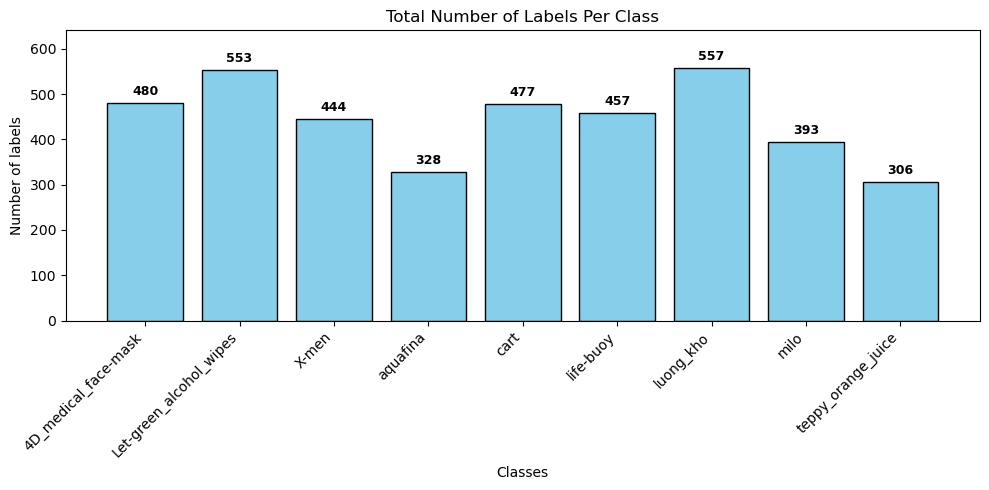

In [4]:
total_counts = defaultdict(int)
for labels_dir in label_dirs:
    if not os.path.exists(labels_dir):
        print(f"Warning: Labels directory does not exist: {labels_dir}")
        continue
    for label_file in glob.glob(os.path.join(labels_dir, "*.txt")):
        with open(label_file, "r") as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if not parts:
                    continue
                class_id = int(parts[0])
                if 0 <= class_id < len(class_names):
                    total_counts[class_names[class_id]] += 1

df_counts = pd.DataFrame({"Class": class_names, "Count": [total_counts.get(cls, 0) for cls in class_names]})
plt.figure(figsize=(10, 5))
bars = plt.bar(df_counts['Class'], df_counts['Count'], color='skyblue', edgecolor='black')

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel("Classes")
plt.ylabel("Number of labels")
plt.title("Total Number of Labels Per Class")

max_count = max(df_counts['Count'])
plt.ylim(0, max_count * 1.15)  # Add 15% padding on top

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + max_count * 0.02,  # Slightly above each bar
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold',
        color='black'
    )

plt.tight_layout()
plt.show()

##### Display example from each class

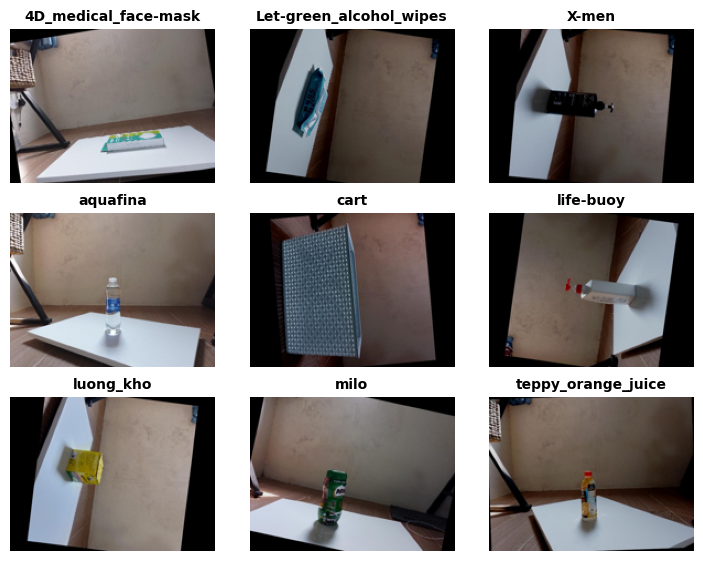

In [5]:
all_examples_per_class = {i: [] for i in range(len(class_names))}

for labels_dir, images_dir in zip(label_dirs, image_dirs):
    for label_file in glob.glob(os.path.join(labels_dir, "*.txt")):
        with open(label_file, "r") as f:
            lines = f.readlines()
        classes_in_file = set()
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            if class_id < len(class_names):
                classes_in_file.add(class_id)
        base_filename = os.path.basename(label_file).rsplit(".", 1)[0]
        for class_id in classes_in_file:
            image_path = os.path.join(images_dir, base_filename + ".jpg")
            all_examples_per_class[class_id].append({"image_path": image_path, "class_name": class_names[class_id]})

found_examples = {}
for class_id, examples in all_examples_per_class.items():
    idx_to_use = 4 if len(examples) > 4 else len(examples) - 1
    found_examples[class_id] = examples[idx_to_use]

num_classes = len(class_names)
cols = 3
rows = (num_classes + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(7.2, rows * 1.9))
axes = axes.flatten()
MAX_IMG_HEIGHT = 140

for idx, class_id in enumerate(sorted(found_examples.keys())):
    ax = axes[idx]
    data = found_examples[class_id]
    img = Image.open(data["image_path"])
    w, h = img.size
    new_h = MAX_IMG_HEIGHT
    new_w = int(w * (new_h / h))
    img = img.resize((new_w, new_h))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"{data['class_name']}", fontsize=10, fontweight='bold', pad=6, loc='center')

plt.tight_layout()
plt.show()

### Mdel Training + Evaluation + Prediction

##### Train the YOLOv8 Models

In [6]:
def train_yolo_models(dataset_yaml, model_variants=None, epochs=75, imgsz=640, batch=25, patience=10):
    for model_name in model_variants:
        print(f"\n🔹 Training {model_name}...\n")
        model = YOLO(model_name)
        results = model.train(data=dataset_yaml, epochs=epochs, imgsz=imgsz, batch=batch, patience=patience, plots=True)
        print(f"✅ Finished training {model_name}\n")
    print("🎯 All models trained successfully!")

train_yolo_models(
    dataset_yaml=os.path.join(dataset.location, "data.yaml"),
    model_variants=['yolov8n.pt', 'yolov8s.pt', 'yolov8m.pt'],
    epochs=75,
    imgsz=640,
    batch=25,
    patience=10
)

[INFO] Training yolov8m.pt...
100%|██████████| 49.7M/49.7M [00:01<00:00, 32.3MB/s]

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
yolo/engine/trainer: task=detect, mode=train, model=yolov8m.

##### Model Benchmarking with Validation Set

In [7]:
def benchmark_yolo_models(model_paths, data_yaml, mode="cli"):
    results_list = []
    for path in model_paths:
        model_name = os.path.basename(path).replace(".pt", "")
        result = subprocess.run(["yolo", "mode=val", f"model={path}", f"data={data_yaml}"], capture_output=True, text=True)
        output = "\n".join([line for line in (result.stdout + result.stderr).splitlines() 
                            if not ("UserWarning" in line or "Cache directory" in line)])
        match = re.search(r"all\s+\d+\s+\d+\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)", output)
        if match:
            p, r, map50, map5095 = map(float, match.groups())
            metrics = {"Model": model_name, "Precision": p, "Recall": r, "mAP@0.5": map50, "mAP@0.5:0.95": map5095}
        if metrics: results_list.append(metrics)

    df = pd.DataFrame(results_list)
    best_model_row = df.loc[df['mAP@0.5:0.95'].idxmax()]
    best_model_path = [p for p in model_paths if os.path.basename(p).replace(".pt","") == best_model_row["Model"]][0]

    return df, YOLO(best_model_path)

# Example usage
model_files = ["models/yolov8n_best.pt", "models/yolov8s_best.pt", "models/yolov8m_best.pt"]
data_yaml = "C:/Users/HP/PGC - AI/FSDSS Project/data/Retail-Product-Checkout-35/data.yaml"

df, model = benchmark_yolo_models(model_files, data_yaml)

# Get the best model row
best_model_row = df.loc[df['mAP@0.5:0.95'].idxmax()]
print("\n🏆 Best Model Summary 🏆")
print("="*40)
print(f"Model: {best_model_row['Model']}")
print(f"mAP@0.5: {best_model_row['mAP@0.5']:.4f}")
print(f"mAP@0.5:0.95: {best_model_row['mAP@0.5:0.95']:.4f}")
print(f"Precision: {best_model_row['Precision']:.4f}")
print(f"Recall: {best_model_row['Recall']:.4f}")
print(f"Reason: Highest mAP@0.5:0.95 (better overall detection performance)")
print("="*40)

df.head()


🏆 Best Model Summary 🏆
Model: yolov8m_best
mAP@0.5: 0.9790
mAP@0.5:0.95: 0.9440
Precision: 0.9680
Recall: 0.9820
Reason: Highest mAP@0.5:0.95 (better overall detection performance)


Model  Precision  Recall  mAP@0.5  mAP@0.5:0.95
0  yolov8n_best      0.969   0.949    0.977         0.918
1  yolov8s_best      0.965   0.977    0.984         0.943
2  yolov8m_best      0.968   0.982    0.979         0.944

##### Run Inference on Test Images

In [8]:
results = model.predict(source=dataset.location + "/test/images", conf=0.4, save=True, save_txt=True)

Ultralytics YOLOv8.0.0  Python-3.8.10 torch-1.10.2+cu102 CUDA:0 (NVIDIA GeForce 940MX, 4096MiB)
Fusing layers... 
Model summary: 218 layers, 25844971 parameters, 0 gradients, 78.7 GFLOPs
image 1/51 C:\Users\HP\PGC - AI\FSDSS Project\data\Retail-Product-Checkout-35\test\images\IMG_5962_JPG.rf.661fb79d823022cabe2cecc0fe75e591.jpg: 640x480 2 4D_medical_face-masks, 1 cart, 171.8ms
image 2/51 C:\Users\HP\PGC - AI\FSDSS Project\data\Retail-Product-Checkout-35\test\images\IMG_5963_JPG.rf.d3f890941c03e5b0a353a03a64dcc4a0.jpg: 640x480 2 4D_medical_face-masks, 1 cart, 165.1ms
image 3/51 C:\Users\HP\PGC - AI\FSDSS Project\data\Retail-Product-Checkout-35\test\images\IMG_5964_JPG.rf.80730cf5d575afb9deb756985662f6b3.jpg: 640x480 2 4D_medical_face-masks, 1 cart, 1 life-buoy, 220.3ms
image 4/51 C:\Users\HP\PGC - AI\FSDSS Project\data\Retail-Product-Checkout-35\test\images\IMG_5967_JPG.rf.306d6e7bcd90e1e14b6c3301f644d6b7.jpg: 640x480 1 X-men, 1 life-buoy, 450.0ms
image 5/51 C:\Users\HP\PGC - AI\FSDSS P

##### Display Predictions

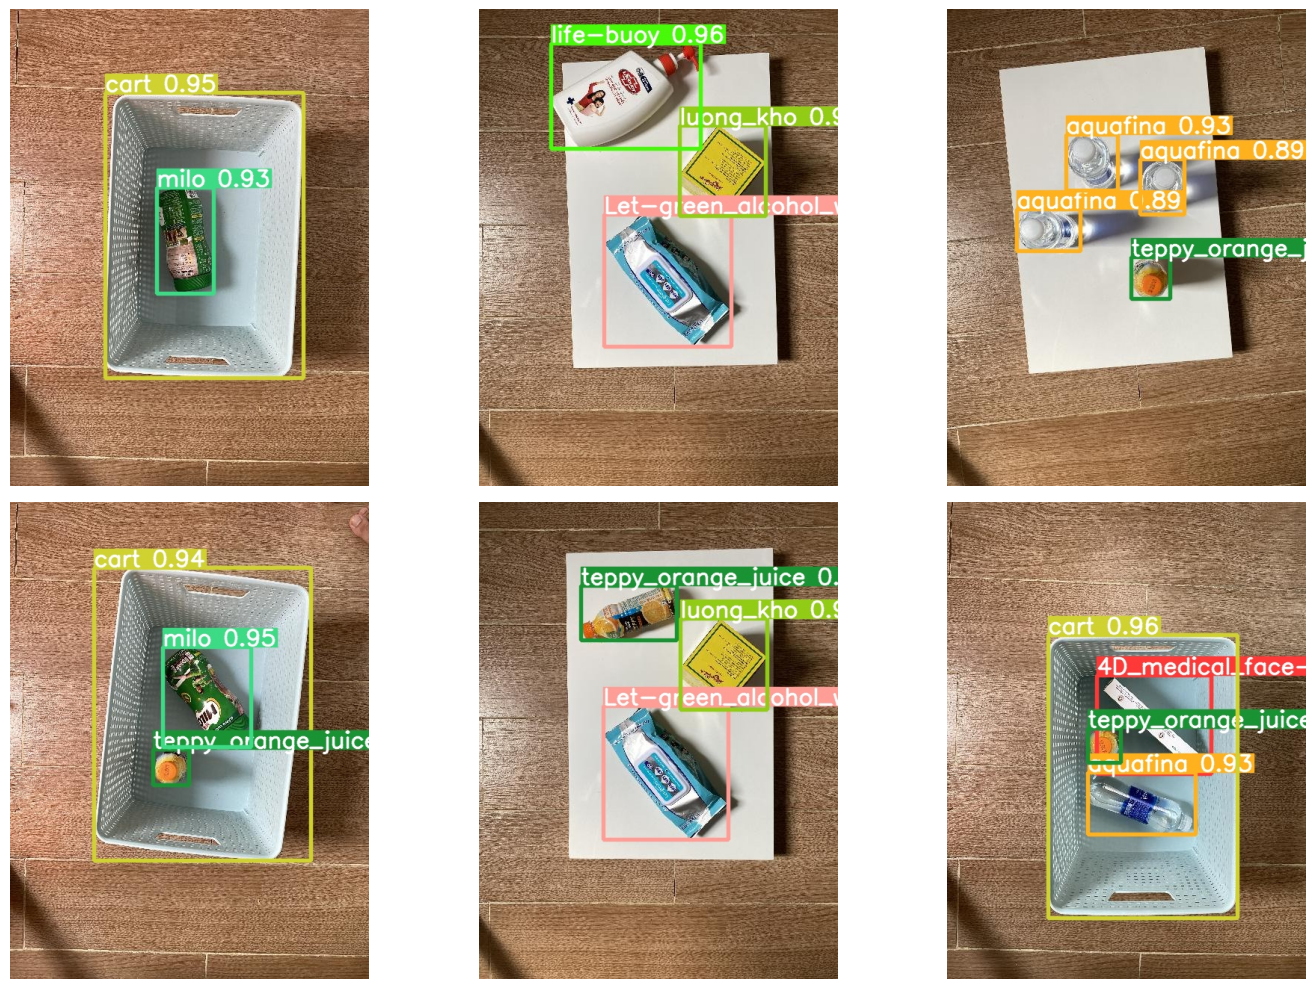

In [9]:
image_paths = glob.glob('runs/detect/predict/*.jpg')

num_images = 6
selected_paths = random.sample(image_paths, min(num_images, len(image_paths)))
cols = 3
rows = (len(selected_paths) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

# Plot each image
for ax, img_path in zip(axes, selected_paths):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

### Post-prediction Analysis

##### Extract Detection Counts per Image

In [10]:
def get_trimmed_image_name(filename):
    base = os.path.basename(filename)
    base_no_ext = base.split('.')[0]
    parts = base_no_ext.split('_')
    trimmed_name = '_'.join(parts[:2])
    return trimmed_name

# Function to extract counts from detections list
def extract_counts_from_detections(detections_list, class_names, image_paths=None):
    image_counts = {}
    for i, detections in enumerate(detections_list):
        if not isinstance(detections, np.ndarray):
            detections = np.array(detections.cpu())
            class_ids = detections[:, 5].astype(int)
            counts_dict = {class_names[cid]: count for cid, count in Counter(class_ids).items()}
        else:
            counts_dict = {}
        image_name = get_trimmed_image_name(image_paths[i]) if image_paths and i < len(image_paths) else f"Image_{i}"
        image_counts[image_name] = counts_dict
    return image_counts

class_names=model.model.names
image_paths = sorted(glob.glob(os.path.join(dataset.location, "test/images", "*.*")))
counts_per_image = extract_counts_from_detections(results, class_names=class_names, image_paths=image_paths)
for img, counts in islice(counts_per_image.items(), 10):
    print(f"{img}: {counts}")

IMG_5962: {'4D_medical_face-mask': 2, 'cart': 1}
IMG_5963: {'4D_medical_face-mask': 2, 'cart': 1}
IMG_5964: {'4D_medical_face-mask': 2, 'life-buoy': 1, 'cart': 1}
IMG_5967: {'life-buoy': 1, 'X-men': 1}
IMG_5968: {'life-buoy': 1, 'X-men': 1}
IMG_5970: {'life-buoy': 1, 'aquafina': 1, 'X-men': 1}
IMG_5972: {'X-men': 1, 'aquafina': 1}
IMG_5975: {'aquafina': 3, 'teppy_orange_juice': 1}
IMG_5976: {'aquafina': 3, 'teppy_orange_juice': 1}
IMG_5977: {'milo': 1, 'teppy_orange_juice': 1}


##### Define per-class stock thresholds (customize these thresholds as needed)
Define threshold rules and classify stock status ("In Stock" or "Out of Stock") based on counts.

In [11]:
stock_thresholds = {
    "4D_medical_face-mask": 3,
    "Let-green_alcohol_wipes": 2,
    "X-men": 1,
    "aquafina": 4,
    "cart": 1,
    "life-buoy": 2,
    "luong_kho": 1,
    "milo": 3,
    "teppy_orange_juice": 2
}

def classify_stock_status(product_count, total_count_all_products, threshold):
    if total_count_all_products == 0:
        return "Out of Stock"
    elif product_count == 0:
        return "Out of Stock"
    elif product_count >= threshold:
        return "OK"
    else:
        return "Below Threshold"

# Get the first image and its counts
first_img = list(counts_per_image.keys())[0]
first_counts = counts_per_image[first_img]
total_count_all_products = sum(first_counts.values())

# Generate stock status for the first image
stock_status = {}
for product, threshold in stock_thresholds.items():
    product_count = first_counts.get(product, 0)
    status = classify_stock_status(product_count, total_count_all_products, threshold)
    stock_status[product] = status

print(f"Stock status for {first_img}:")
print(stock_status)

Stock status for IMG_5962:
{'4D_medical_face-mask': 'Below Threshold', 'Let-green_alcohol_wipes': 'Out of Stock', 'X-men': 'Out of Stock', 'aquafina': 'Out of Stock', 'cart': 'OK', 'life-buoy': 'Out of Stock', 'luong_kho': 'Out of Stock', 'milo': 'Out of Stock', 'teppy_orange_juice': 'Out of Stock'}


##### Generate Shelf status report

In [12]:
# Generate generic shelf status report (dict + DataFrame)
def generate_shelf_status_report(detections_list, class_names, stock_thresholds, image_paths):
    counts_per_image = extract_counts_from_detections(detections_list, class_names, image_paths=image_paths)
    df_rows = []

    for image_name, counts in counts_per_image.items():
        total_count_all_products = sum(counts.values())
        image_statuses = {}

        for product, threshold in stock_thresholds.items():
            product_count = counts.get(product, 0)
            status = classify_stock_status(product_count, total_count_all_products, threshold)
            image_statuses[product] = status
            df_rows.append({"Image": image_name, "Product": product, "Count": product_count, "Status": status})

    shelf_status_report_df = pd.DataFrame(df_rows)
    return shelf_status_report_df

image_paths = sorted(glob.glob(os.path.join(dataset.location, "test/images", "*.*")))
df_report = generate_shelf_status_report(results, class_names, stock_thresholds, image_paths)
df_report.head()

Image                  Product  Count           Status
0  IMG_5962     4D_medical_face-mask      2  Below Threshold
1  IMG_5962  Let-green_alcohol_wipes      0     Out of Stock
2  IMG_5962                    X-men      0     Out of Stock
3  IMG_5962                 aquafina      0     Out of Stock
4  IMG_5962                     cart      1               OK

### Final Results

##### On Image

Ultralytics YOLOv8.0.0  Python-3.8.10 torch-1.10.2+cu102 CUDA:0 (NVIDIA GeForce 940MX, 4096MiB)
Fusing layers... 
Model summary: 218 layers, 25844971 parameters, 0 gradients
image 1/1 C:\Users\HP\PGC - AI\FSDSS Project\Image1.jpg: 640x448 1 4D_medical_face-mask, 2 aquafinas, 3 life-buoys, 1 luong_kho, 7 milos, 2 teppy_orange_juices, 170.0ms
Speed: 0.0ms pre-process, 170.0ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to temp\predict


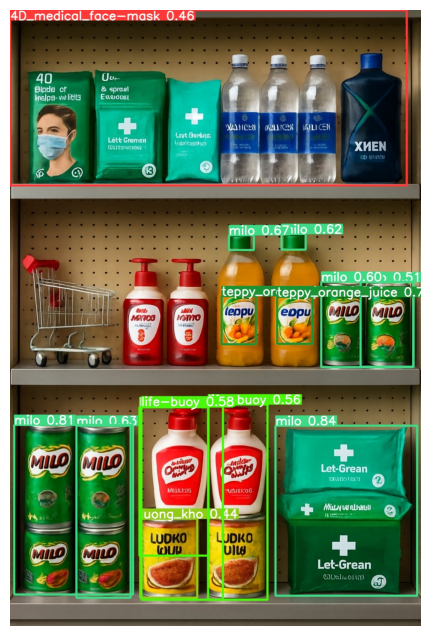

Count           Status
Image  Product                                        
Image1 4D_medical_face-mask         1  Below Threshold
       Let-green_alcohol_wipes      0     Out of Stock
       X-men                        0     Out of Stock
       aquafina                     2  Below Threshold
       cart                         0     Out of Stock
       life-buoy                    3               OK
       luong_kho                    1               OK
       milo                         7               OK
       teppy_orange_juice           2               OK

In [13]:
image_paths = ['C:/Users/HP/PGC - AI/FSDSS Project/Image1.jpg']
detections_list = []
for img_path in image_paths:
    results = model.predict(source=img_path, conf=0.4, save=True, project='temp', exist_ok=True)
    detections = results[0]
    detections_list.append(detections)  
    saved_img_path = os.path.join('temp', 'predict', os.listdir(os.path.join('temp', 'predict'))[0])
    img = mpimg.imread(saved_img_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    shutil.rmtree('temp')

df_report = generate_shelf_status_report(detections_list, class_names, stock_thresholds, image_paths)
df_report.groupby(['Image', 'Product']).max()

##### On Video

In [14]:
def detect_and_save_video(input_path, output_path, model_path, conf_threshold=0.25, frame_dir="detected_frames"):
    model = YOLO(model_path)

    # Read video
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open video {input_path}")

    os.makedirs(frame_dir, exist_ok=True)

    # Video writer setup
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    fps = cap.get(cv2.CAP_PROP_FPS) or 20.0
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Save frames
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret: break
        frame_count += 1
        cv2.imwrite(os.path.join(frame_dir, f"frame_{frame_count:05d}.jpg"), frame)

    cap.release()

    # Run detection & save annotated frames
    model.predict(source=frame_dir, conf=conf_threshold, save=True, project=frame_dir, name="preds", exist_ok=True)
    pred_dir = os.path.join(frame_dir, "preds")
    saved_frames = sorted([f for f in os.listdir(pred_dir) if f.lower().endswith(('.jpg'))])

    # Write processed frames into video
    for frame_file in saved_frames:
        img = cv2.imread(os.path.join(pred_dir, frame_file))
        out.write(cv2.resize(img, (width, height)))

    out.release()
    cv2.destroyAllWindows()
    shutil.rmtree(frame_dir)
    print(f"Processed video saved to: {output_path}")
    

detect_and_save_video(
    input_path="IMG-5962-JPGrf661fb79d823022cabe.mp4",
    output_path="static/output_detected.mp4",
    model_path=r"C:\Users\HP\PGC - AI\FSDSS Project\runs\detect\train\weights\best.pt"
)

Ultralytics YOLOv8.0.0  Python-3.8.10 torch-1.10.2+cu102 CUDA:0 (NVIDIA GeForce 940MX, 4096MiB)
Fusing layers... 
Model summary: 168 layers, 3007403 parameters, 0 gradients, 8.1 GFLOPs
image 1/48 C:\Users\HP\PGC - AI\FSDSS Project\detected_frames\frame_00001.jpg: 640x480 4 4D_medical_face-masks, 55.2ms
image 2/48 C:\Users\HP\PGC - AI\FSDSS Project\detected_frames\frame_00002.jpg: 640x480 4 4D_medical_face-masks, 211.6ms
image 3/48 C:\Users\HP\PGC - AI\FSDSS Project\detected_frames\frame_00003.jpg: 640x480 4 4D_medical_face-masks, 213.2ms
image 4/48 C:\Users\HP\PGC - AI\FSDSS Project\detected_frames\frame_00004.jpg: 640x480 4 4D_medical_face-masks, 238.8ms
image 5/48 C:\Users\HP\PGC - AI\FSDSS Project\detected_frames\frame_00005.jpg: 640x480 4 4D_medical_face-masks, 182.8ms
image 6/48 C:\Users\HP\PGC - AI\FSDSS Project\detected_frames\frame_00006.jpg: 640x480 4 4D_medical_face-masks, 216.1ms
image 7/48 C:\Users\HP\PGC - AI\FSDSS Project\detected_frames\frame_00007.jpg: 640x480 4 4D_medi

Processed video saved to: static/output_detected.mp4


### Flask App

In [15]:
app = Flask(__name__)

model_path = r"C:\Users\HP\PGC - AI\FSDSS Project\runs\detect\train\weights\best.pt"
model = YOLO(model_path)
class_names = model.model.names

DEFAULT_STOCK_THRESHOLDS = {
    "4D_medical_face-mask": 3,
    "Let-green_alcohol_wipes": 2,
    "X-men": 1,
    "aquafina": 4,
    "cart": 1,
    "life-buoy": 2,
    "luong_kho": 1,
    "milo": 3,
    "teppy_orange_juice": 2
}

HTML_TEMPLATE = """
<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8" />
<meta name="viewport" content="width=device-width, initial-scale=1" />
<title>YOLOv8 Multi-Image & Video Detection & Shelf Report</title>
<style>
  body { font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; background: #f0f4f8; color: #222; margin: 0; padding: 20px; }
  h1 { text-align: center; margin-bottom: 30px; color: #0d47a1; }
  .container { max-width: 1200px; margin: 0 auto; display: flex; gap: 40px; flex-wrap: wrap; }
  .panel { background: white; border-radius: 10px; padding: 20px 25px; box-shadow: 0 4px 15px rgb(0 0 0 / 0.1); margin-bottom: 30px; flex: 1 1 400px; }
  h2 { text-align: center; margin-bottom: 20px; color: #0d47a1; }
  .slider-group { display: flex; justify-content: space-between; align-items: center; margin-bottom: 15px; }
  .slider-group label { flex: 1 1 130px; font-weight: 600; font-size: 15px; color: #333; }
  .slider-group input[type=range] { flex: 1 1 120px; margin: 0 12px; cursor: pointer; }
  .slider-value { width: 30px; font-weight: 600; color: #0d47a1; text-align: center; }
  .btn-update { display: block; width: 100%; background-color: #0d47a1; color: white; font-size: 16px; padding: 12px 0; border: none; border-radius: 8px; cursor: pointer; margin-top: 25px; transition: background-color 0.3s ease; }
  .btn-update:hover { background-color: #084c8d; }
  form.upload-form { margin-bottom: 30px; display: flex; gap: 15px; justify-content: center; align-items: center; flex-wrap: wrap; }
  form.upload-form input[type="file"] { cursor: pointer; }
  form.upload-form input[type="submit"] { background-color: #0d47a1; border: none; color: white; padding: 10px 25px; font-size: 16px; border-radius: 8px; cursor: pointer; transition: background-color 0.3s ease; }
  form.upload-form input[type="submit"]:hover { background-color: #084c8d; }
  .gallery { display: grid; grid-template-columns: repeat(auto-fit, minmax(280px, 1fr)); gap: 25px; margin-bottom: 40px; }
  .image-card { background: #fafafa; border-radius: 10px; box-shadow: 0 3px 10px rgb(0 0 0 / 0.12); padding: 15px; text-align: center; }
  .image-card img { max-width: 100%; border-radius: 10px; box-shadow: 0 3px 12px rgb(0 0 0 / 0.15); margin-bottom: 15px; }
  .image-card table { margin: 0 auto; border-collapse: collapse; width: 90%; font-size: 14px; }
  .image-card th, .image-card td { border: 1px solid #ddd; padding: 6px 8px; text-align: center; }
  .image-card th { background-color: #0d47a1; color: white; }
  table.shelf-report { width: 100%; border-collapse: collapse; margin-bottom: 20px; }
  table.shelf-report, table.shelf-report th, table.shelf-report td { border: 1px solid #ddd; }
  table.shelf-report th, table.shelf-report td { padding: 12px 10px; text-align: center; }
  table.shelf-report th { background-color: #0d47a1; color: white; }
  table.shelf-report tr:nth-child(even) { background-color: #f6f9ff; }
  .status-ok { color: green; font-weight: 700; }
  .status-below { color: #d32f2f; font-weight: 700; }
  .status-out { color: #757575; font-style: italic; }
  @media (max-width: 900px) { .container { flex-direction: column; } .panel { flex: 1 1 100%; } }
</style>
</head>
<body>

<h1>AI-Powered Autonomous Retail Shelf Monitoring System</h1>

<div class="container">
  <div class="panel">
    <h2>Adjust Stock Thresholds</h2>
    <form method="POST" id="thresholds-form">
      {% for product, val in thresholds.items() %}
      <div class="slider-group">
        <label for="threshold_{{ loop.index }}">{{ product }}</label>
        <input type="range" min="0" max="10" step="1" id="threshold_{{ loop.index }}" name="threshold_{{ product }}" value="{{ val }}" oninput="document.getElementById('val_{{ loop.index }}').textContent = this.value" />
        <div class="slider-value" id="val_{{ loop.index }}">{{ val }}</div>
      </div>
      {% endfor %}
      <button type="submit" name="set_thresholds" class="btn-update">Update Thresholds & Clear Images</button>
    </form>
  </div>

  <div class="panel">
    <h2>Upload Images for Detection</h2>
    <form method="POST" enctype="multipart/form-data" class="upload-form" action="/">
      {% for product, val in thresholds.items() %}
        <input type="hidden" name="threshold_{{ product }}" value="{{ val }}">
      {% endfor %}
      <input type="file" name="images" accept="image/*" multiple required />
      <input type="submit" value="Upload and Detect" />
    </form>

    <h2>Upload Video for Detection</h2>
    <form method="POST" enctype="multipart/form-data" class="upload-form" action="/upload_video">
      <input type="file" name="video" accept="video/*" required />
      <input type="submit" value="Upload and Process Video" />
    </form>
  </div>
</div>

{% if images_results %}
<div class="container">
  <div class="panel" style="flex: 1 1 100%;">
    <h2>Image Detection Results</h2>
    <div class="gallery">
      {% for img_res in images_results %}
      <div class="image-card">
        <img src="{{ img_res.img_url }}" alt="Result image {{ loop.index }}" />
        <table>
          <thead>
            <tr><th>Product</th><th>Count</th><th>Avg Confidence</th></tr>
          </thead>
          <tbody>
            {% for item in img_res.detections %}
            <tr>
              <td>{{ item.product }}</td>
              <td>{{ item.count }}</td>
              <td>{{ "%.2f"|format(item.avg_confidence) }}</td>
            </tr>
            {% endfor %}
          </tbody>
        </table>
      </div>
      {% endfor %}
    </div>

    <h2>Consolidated Shelf Status Report</h2>
    <table class="shelf-report">
      <thead>
        <tr>
          <th>Product</th>
          <th>Total Count</th>
          <th>Average Confidence</th>
          <th>Status</th>
        </tr>
      </thead>
      <tbody>
        {% for row in consolidated_report %}
        <tr>
          <td>{{ row.product }}</td>
          <td>{{ row.total_count }}</td>
          <td>{{ "%.2f"|format(row.avg_confidence) }}</td>
          <td class="
            {% if row.status == 'OK' %}status-ok
            {% elif row.status == 'Below Threshold' %}status-below
            {% else %}status-out
            {% endif %}
          ">{{ row.status }}</td>
        </tr>
        {% endfor %}
      </tbody>
    </table>
  </div>
</div>
{% endif %}

{% if video_url %}
<div class="container">
  <div class="panel" style="flex: 1 1 100%;">
    <h2>Processed Video Result</h2>
    <video width="720" height="480" controls>
      <source src="{{ video_url }}" type="video/mp4">
      Your browser does not support the video tag.
    </video>
  </div>
</div>
{% endif %}

</body>
</html>
"""

def classify_stock_status(product_count, total_count_all_products, threshold):
    if total_count_all_products == 0:
        return "Out of Stock"
    elif product_count == 0:
        return "Out of Stock"
    elif product_count >= threshold:
        return "OK"
    else:
        return "Below Threshold"

@app.route("/", methods=["GET", "POST"])
def upload_image():
    thresholds = DEFAULT_STOCK_THRESHOLDS.copy()
    images_results = []
    consolidated_counts = {}
    consolidated_conf_sums = {}

    if request.method == "POST" and "set_thresholds" in request.form:
        new_thresholds = {}
        for product in DEFAULT_STOCK_THRESHOLDS:
            key = f"threshold_{product}"
            val = request.form.get(key)
            try:
                val_int = int(val)
                if val_int < 0:
                    val_int = 0
                new_thresholds[product] = val_int
            except Exception:
                new_thresholds[product] = DEFAULT_STOCK_THRESHOLDS[product]
        thresholds = new_thresholds
        return render_template_string(HTML_TEMPLATE, thresholds=thresholds)

    if request.method == "POST" and "images" in request.files:
        for product in DEFAULT_STOCK_THRESHOLDS:
            key = f"threshold_{product}"
            val = request.form.get(key)
            if val:
                try:
                    thresholds[product] = max(0, int(val))
                except Exception:
                    pass

        files = request.files.getlist("images")
        if not files or len(files) == 0:
            return render_template_string(HTML_TEMPLATE, thresholds=thresholds)

        project_folder = os.path.join(app.root_path, "static", "predictions")
        if os.path.exists(project_folder):
            shutil.rmtree(project_folder)
        os.makedirs(project_folder, exist_ok=True)

        uploads_folder = os.path.join(app.root_path, "static", "image_results")
        os.makedirs(uploads_folder, exist_ok=True)

        detections_list = []
        saved_image_paths = []

        for file in files:
            if file and file.filename != "":
                with tempfile.TemporaryDirectory() as temp_dir:
                    file_path = os.path.join(temp_dir, file.filename)
                    file.save(file_path)

                    results = model.predict(
                        source=file_path,
                        conf=0.4,
                        save=True,
                        project=project_folder,
                        name="predict",
                        exist_ok=True
                    )
                    detections = results[0].detach().cpu().numpy() if len(results) > 0 else []
                    detections_list.append(detections)

                    saved_imgs_dir = os.path.join(project_folder, "predict")
                    saved_files = sorted(os.listdir(saved_imgs_dir))
                    saved_img_filename = saved_files[-1]  # last saved image

                    # Copy to permanent uploads folder
                    src_path = os.path.join(saved_imgs_dir, saved_img_filename)
                    dst_path = os.path.join(uploads_folder, saved_img_filename)
                    shutil.copy(src_path, dst_path)

                    # Save relative path from static folder for URL
                    saved_image_paths.append(f"image_results/{saved_img_filename}")

        # Delete predictions folder after copying files
        shutil.rmtree(project_folder)

        for idx, detections in enumerate(detections_list):
            counts = {}
            conf_sums = {}

            for det in detections:
                _, _, _, _, conf, cls_id = det
                cls_id = int(cls_id)
                cls_name = class_names.get(cls_id, str(cls_id))
                counts[cls_name] = counts.get(cls_name, 0) + 1
                conf_sums[cls_name] = conf_sums.get(cls_name, 0.0) + conf

            img_detections = []
            for product in thresholds:
                count = counts.get(product, 0)
                avg_conf = conf_sums.get(product, 0.0) / count if count > 0 else 0.0
                img_detections.append({"product": product, "count": count, "avg_confidence": avg_conf})
                consolidated_counts[product] = consolidated_counts.get(product, 0) + count
                consolidated_conf_sums[product] = consolidated_conf_sums.get(product, 0.0) + conf_sums.get(product, 0.0)

            images_results.append({
                "img_url": url_for('static', filename=saved_image_paths[idx].replace(os.path.sep, "/")),
                "detections": img_detections
            })

        total_count_all_products = sum(consolidated_counts.values())
        consolidated_report = []
        for product in thresholds:
            total_count = consolidated_counts.get(product, 0)
            total_conf = consolidated_conf_sums.get(product, 0.0)
            avg_conf = (total_conf / total_count) if total_count > 0 else 0.0
            threshold = thresholds[product]
            status = classify_stock_status(total_count, total_count_all_products, threshold)
            consolidated_report.append({
                "product": product,
                "total_count": total_count,
                "avg_confidence": avg_conf,
                "status": status
            })

        return render_template_string(
            HTML_TEMPLATE,
            thresholds=thresholds,
            images_results=images_results,
            consolidated_report=consolidated_report
        )

    # GET request
    return render_template_string(HTML_TEMPLATE, thresholds=thresholds)


@app.route('/video/<filename>')
def serve_video(filename):
    static_folder = os.path.join(app.root_path, "static")
    return send_from_directory(static_folder, filename)


@app.route("/upload_video", methods=["GET", "POST"])
def upload_video():
    if request.method == "POST":
        video_file = request.files.get("video")
        if not video_file or video_file.filename == "":
            return "No video file uploaded", 400

        with tempfile.TemporaryDirectory() as temp_dir:
            input_video_path = os.path.join(temp_dir, video_file.filename)
            video_file.save(input_video_path)

            static_folder = os.path.join(app.root_path, "static")
            os.makedirs(static_folder, exist_ok=True)

            output_filename = f"Result_{uuid.uuid4().hex}.mp4"
            output_path = os.path.join(static_folder, output_filename)

            frame_dir = os.path.join(temp_dir, "frames")
            os.makedirs(frame_dir, exist_ok=True)

            cap = cv2.VideoCapture(input_video_path)
            if not cap.isOpened():
                return "Failed to open uploaded video", 400

            frame_count = 0
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                frame_count += 1
                frame_path = os.path.join(frame_dir, f"frame_{frame_count:05d}.jpg")
                cv2.imwrite(frame_path, frame)
            cap.release()

            model.predict(source=frame_dir, conf=0.25, save=True, project=frame_dir, name="preds", exist_ok=True)

            pred_dir = os.path.join(frame_dir, "preds")
            saved_frames = sorted([f for f in os.listdir(pred_dir) if f.lower().endswith('.jpg')])

            cap = cv2.VideoCapture(input_video_path)
            fps = cap.get(cv2.CAP_PROP_FPS) or 20.0
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            cap.release()

            fourcc = cv2.VideoWriter_fourcc(*"X264")
            out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

            for frame_file in saved_frames:
                img = cv2.imread(os.path.join(pred_dir, frame_file))
                if img.shape[1] != width or img.shape[0] != height:
                    img = cv2.resize(img, (width, height))
                out.write(img)
            out.release()

            # DEBUG prints only here after successful save
            print(f"Video saved at: {output_path}")
            video_url = url_for("static", filename=output_filename)
            print(f"Video URL: {video_url}")

            shutil.rmtree(frame_dir)

        return render_template_string(HTML_TEMPLATE, thresholds=DEFAULT_STOCK_THRESHOLDS, video_url=video_url)

    # GET fallback form
    return """
    <h1>Upload Video for Detection</h1>
    <form method="POST" enctype="multipart/form-data">
        <input type="file" name="video" accept="video/*" required />
        <input type="submit" value="Upload and Process Video" />
    </form>
    """

if __name__ == "__main__":
    app.run(debug=True, use_reloader=False)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [13/Aug/2025 20:00:25] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [13/Aug/2025 20:00:25] "GET /favicon.ico HTTP/1.1" 404 -
Ultralytics YOLOv8.0.0  Python-3.8.10 torch-1.10.2+cu102 CUDA:0 (NVIDIA GeForce 940MX, 4096MiB)
Fusing layers... 
Model summary: 168 layers, 3007403 parameters, 0 gradients, 8.1 GFLOPs
image 1/1 C:\Users\HP\AppData\Local\Temp\tmp695obuqb\Image1.jpg: 640x448 2 4D_medical_face-masks, 1 cart, 2 life-buoys, 6 milos, 3 teppy_orange_juices, 266.5ms
Speed: 10.7ms pre-process, 266.5ms inference, 21.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to C:\Users\HP\PGC - AI\FSDSS Project\static\predictions\predict
Ultralytics YOLOv8.0.0  Python-3.8.10 torch-1.10.2+cu102 CUDA:0 (NVIDIA GeForce 940MX, 4096MiB)
Fusing layers... 
Model summary: 168 layers, 3007403 parameters, 0 gradients, 8.1 GFLOPs
image 1/1 C:\Users\HP\AppData\Local\Temp\tmp28_qni9y\Image2.jpg: 640x480 1 Let-green_alcohol_wipes, 1 

Video saved at: C:\Users\HP\PGC - AI\FSDSS Project\static\Result_2e1240fbef254ecf834b68d67f874646.mp4
Video URL: /static/Result_2e1240fbef254ecf834b68d67f874646.mp4


127.0.0.1 - - [13/Aug/2025 20:02:31] "GET /static/Result_2e1240fbef254ecf834b68d67f874646.mp4 HTTP/1.1" 206 -


### Docker File

In [16]:
dockerfile_content = """\
# Use Python
FROM python:3.8-slim-bullseye

# Prevent Python output buffering
ENV PYTHONUNBUFFERED=1

# Set working directory
WORKDIR /app

# Install system dependencies
RUN apt-get update && apt-get install -y --no-install-recommends \\
    build-essential \\
    libgl1-mesa-glx \\
    libglib2.0-0 \\
    git \\
    wget \\
    ca-certificates \\
    && rm -rf /var/lib/apt/lists/*

# Install static build of ffmpeg with libx264 included
RUN wget https://johnvansickle.com/ffmpeg/releases/ffmpeg-release-amd64-static.tar.xz \\
    && tar -xJf ffmpeg-release-amd64-static.tar.xz \\
    && cp ffmpeg-*-amd64-static/ffmpeg /usr/local/bin/ffmpeg \\
    && cp ffmpeg-*-amd64-static/ffprobe /usr/local/bin/ffprobe \\
    && rm -rf ffmpeg-release-amd64-static.tar.xz ffmpeg-*-amd64-static


# Copy requirements first
COPY requirements.txt .

# Install Python dependencies
RUN pip install --upgrade pip
RUN pip install --no-cache-dir torch==1.10.2+cu102 -f https://download.pytorch.org/whl/cu102/torch_stable.html
RUN pip install --no-cache-dir -r requirements.txt

# Copy the project
COPY . .

# Expose port
EXPOSE 5000

# Run directly with Python
CMD ["python", "run.py"]
"""

# Write to Dockerfile
with open("Dockerfile", "w") as f:
    f.write(dockerfile_content)

print("Dockerfile created successfully.")

Dockerfile created successfully.
